# Setup

Download the Task data and evaluation scripts

In [ ]:
!git clone https://github.com/niyaryca/Idiomacity-Detection.git

Cloning into 'Idiomacity-Detection'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 95 (delta 43), reused 39 (delta 17), pack-reused 0
Unpacking objects: 100% (95/95), done.


Download and install an editable version of huggingfaces transformers.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.3 MB/s eta 0:00:00


Required for run_glue ...

In [ ]:
## run_glue needs this.
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Editable install requires runtime restart unless we do this.

In [ ]:
import site
site.main()


# Imports and Helper functions

In [ ]:
import os
import csv

from pathlib import Path

In [ ]:
def load_csv( path, delimiter=',' ) :
  header = None
  data   = list()
  with open( path, encoding='utf-8') as csvfile:
    reader = csv.reader( csvfile, delimiter=delimiter )
    for row in reader :
      if header is None :
        header = row
        continue
      data.append( row )
  return header, data


In [ ]:
def write_csv( data, location ) :
  with open( location, 'w', encoding='utf-8') as csvfile:
    writer = csv.writer( csvfile )
    writer.writerows( data )
  print( "Wrote {}".format( location ) )
  return


The following function creates a submission file from the predictions output by run_glue (the text classification script from huggingface transformers - see below).

Note that we set it up so we can load up results for only one setting.

It requires as input the submission format file, which is available with the data. You can call this after completing each setting to load up results for both settings (see below).


In [ ]:
def insert_to_submission_file( submission_format_file, input_file, prediction_format_file, setting ) :
    submission_header, submission_content = load_csv( submission_format_file )
    input_header     , input_data         = load_csv( input_file             )
    prediction_header, prediction_data    = load_csv( prediction_format_file, '\t' )

    assert len( input_data ) == len( prediction_data )

    ## submission_header ['ID', 'Language', 'Setting', 'Label']
    ## input_header      ['label', 'sentence1' ]
    ## prediction_header ['index', 'prediction']

    prediction_data = list( reversed( prediction_data ) )

    started_insert  = False
    for elem in submission_content :
        if elem[ submission_header.index( 'Setting' ) ] != setting :
            if started_insert :
                if len( prediction_data ) == 0 :
                    break
                else :
                    raise Exception( "Update should to contiguous ... something wrong." )
            continue
        started_insert = True
        elem[ submission_header.index( 'Label' ) ] = prediction_data.pop()[ prediction_header.index( 'prediction' ) ]

    return [ submission_header ] + submission_content

# Pre-process: Create train and dev and evaluation data in required format

In the zero-shot setting, we choose to include the context (the sentences preceding and succeeding the one containing the idioms). We do not add the idiom as an additional feature (in the “second input sentence”).

In the one shot setting, we train the model on both the zero-shot and one-shot data. In this setting, we exclude the context (the sentences preceding and succeeding the one containing the idioms) and also add the idiom as an additional feature in the “second sentence”.


## Functions for pre-processing

### _get_train_data

This function generates training data in the format required by the huggingface’s example script. It will include and exclude the MWE and the context based on parameters.


In [ ]:
def _get_train_data( data_location, file_name, include_context, include_idiom ) :

    file_name = os.path.join( data_location, file_name )

    header, data = load_csv( file_name )

    out_header = [ 'label', 'sentence1' ]
    if include_idiom :
        out_header = [ 'label', 'sentence1', 'sentence2' ]

    # ['DataID', 'Language', 'MWE', 'Setting', 'Previous', 'Target', 'Next', 'Label']
    out_data = list()
    for elem in data :
        label     = elem[ header.index( 'Label'  ) ]
        sentence1 = elem[ header.index( 'Target' ) ]
        if include_context :
            sentence1 = ' '.join( [ elem[ header.index( 'Previous' ) ], elem[ header.index( 'Target' ) ], elem[ header.index( 'Next' ) ] ] )
        this_row = None
        if not include_idiom :
            this_row = [ label, sentence1 ]
        else :
            sentence2 = elem[ header.index( 'MWE' ) ]
            this_row = [ label, sentence1, sentence2 ]
        out_data.append( this_row )
        assert len( out_header ) == len( this_row )
    return [ out_header ] + out_data

### _get_dev_eval_data

This function generates training dev and eval data in the format required by the huggingface’s example script. It will include and exclude the MWE and the context based on parameters.

Additionally, if there is no gold label provides (as in the case of eval) it will generate a file that can be used to generate predictions.


In [ ]:
def _get_dev_eval_data( data_location, input_file_name, gold_file_name, include_context, include_idiom ) :

    input_headers, input_data = load_csv( os.path.join( data_location, input_file_name ) )
    gold_header  = gold_data = None
    if not gold_file_name is None :
        gold_header  , gold_data  = load_csv( os.path.join( data_location, gold_file_name  ) )
        assert len( input_data ) == len( gold_data )

    # ['ID', 'Language', 'MWE', 'Previous', 'Target', 'Next']
    # ['ID', 'DataID', 'Language', 'Label']

    out_header = [ 'label', 'sentence1' ]
    if include_idiom :
        out_header = [ 'label', 'sentence1', 'sentence2' ]

    out_data = list()
    for index in range( len( input_data ) ) :
        label = 1
        if not gold_file_name is None :
            this_input_id = input_data[ index ][ input_headers.index( 'ID' ) ]
            this_gold_id  = gold_data [ index ][ gold_header  .index( 'ID' ) ]
            assert this_input_id == this_gold_id

            label     = gold_data[ index ][ gold_header.index( 'Label'  ) ]

        elem      = input_data[ index ]
        sentence1 = elem[ input_headers.index( 'Target' ) ]
        if include_context :
            sentence1 = ' '.join( [ elem[ input_headers.index( 'Previous' ) ], elem[ input_headers.index( 'Target' ) ], elem[ input_headers.index( 'Next' ) ] ] )
        this_row = None
        if not include_idiom :
            this_row = [ label, sentence1 ]
        else :
            sentence2 = elem[ input_headers.index( 'MWE' ) ]
            this_row = [ label, sentence1, sentence2 ]
        assert len( out_header ) == len( this_row )
        out_data.append( this_row )


    return [ out_header ] + out_data


### create_data

This function generates the training, development and evaluation data.


In [ ]:
def create_data( input_location, output_location ) :


    ## Zero shot data
    train_data = _get_train_data(
        data_location   = input_location,
        file_name       = 'train_zero_shot_balanced.csv',
        include_context = True,
        include_idiom   = False
    )
    write_csv( train_data, os.path.join( output_location, 'ZeroShot', 'train.csv' ) )

    dev_data = _get_dev_eval_data(
        data_location    = input_location,
        input_file_name  = 'dev.csv',
        gold_file_name   = 'dev_gold.csv',
        include_context  = True,
        include_idiom    = False
    )
    write_csv( dev_data, os.path.join( output_location, 'ZeroShot', 'dev.csv' ) )

    eval_data = _get_dev_eval_data(
        data_location    = input_location,
        input_file_name  = 'eval.csv',
        gold_file_name   = None ,
        include_context  = True,
        include_idiom    = False
    )
    write_csv( eval_data, os.path.join( output_location, 'ZeroShot', 'eval.csv' ) )


    ## OneShot Data (combine both for training)
    train_zero_data = _get_train_data(
        data_location   = input_location,
        file_name       = 'train_one_shot_balanced.csv',
        include_context = False,
        include_idiom   = True
    )
    train_one_data = _get_train_data(
        data_location   = input_location,
        file_name       = 'train_one_shot.csv',
        include_context = False,
        include_idiom   = True
    )

    assert train_zero_data[0] == train_one_data[0] ## Headers
    train_data = train_one_data + train_zero_data[1:]
    write_csv( train_data, os.path.join( output_location, 'OneShot', 'train.csv' ) )

    dev_data = _get_dev_eval_data(
        data_location    = input_location,
        input_file_name  = 'dev.csv',
        gold_file_name   = 'dev_gold.csv',
        include_context  = False,
        include_idiom    = True
    )
    write_csv( dev_data, os.path.join( output_location, 'OneShot', 'dev.csv' ) )

    eval_data = _get_dev_eval_data(
        data_location    = input_location,
        input_file_name  = 'eval.csv',
        gold_file_name   = None,
        include_context  = False,
        include_idiom    = True
    )
    write_csv( eval_data, os.path.join( output_location, 'OneShot', 'eval.csv' ) )

    return

## Setup and Create data

In [ ]:
zero_shot = pd.read_csv('/content/Idiomacity-Detection/Rawdata/train_zero_shot_balanced.csv')
print('Zero-shot Language Labels\n' , zero_shot['Language'].value_counts())

print('\n')

one_shot = pd.read_csv('/content/Idiomacity-Detection/Rawdata/train_one_shot_balanced.csv')
print('One-shot Language Labels\n' , one_shot['Language'].value_counts())

Zero-shot Language Labels
 EN    1164
PT    1164
Name: Language, dtype: int64


One-shot Language Labels
 EN    53
PT    53
Name: Language, dtype: int64


In [ ]:
outpath = 'Data'

Path( os.path.join( outpath, 'ZeroShot' ) ).mkdir(parents=True, exist_ok=True)
Path( os.path.join( outpath, 'OneShot' ) ).mkdir(parents=True, exist_ok=True)

create_data('/content/Idiomacity-Detection/Rawdata/', outpath )


Wrote Data/ZeroShot/train.csv
Wrote Data/ZeroShot/dev.csv
Wrote Data/ZeroShot/eval.csv
Wrote Data/OneShot/train.csv
Wrote Data/OneShot/dev.csv
Wrote Data/OneShot/eval.csv


# Zero Shot Setting

## Train Zero shot

In [ ]:
!python /content/Idiomacity-Detection/py_codes/run_glue_f1_macro.py \
    	--model_name_or_path 'xlm-roberta-large' \
    	--do_train \
    	--do_eval \
    	--max_seq_length 128 \
    	--per_device_train_batch_size 32 \
    	--learning_rate 2e-5 \
    	--num_train_epochs 9 \
    	--evaluation_strategy "epoch" \
    	--output_dir models/ZeroShot/0/ \
    	--seed 0 \
    	--train_file      Data/ZeroShot/train.csv \
    	--validation_file Data/ZeroShot/dev.csv \
	    --evaluation_strategy "epoch" \
	    --save_strategy "epoch"  \
	    --load_best_model_at_end \
	    --metric_for_best_model "f1" \
	    --save_total_limit 1

2023-01-13 17:12:37.194416: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
## Create save path
# !mkdir -p /content/gdrive/MyDrive/ColabData/Idimaticity_Detection/ZeroShot/0/
## Copy saved model.
!cp -r /content/models/ZeroShot/0/ #* /content/gdrive/MyDrive/ColabData/Idimaticity_Detection/ZeroShot/0/

cp: missing destination file operand after '/content/models/ZeroShot/0/'
Try 'cp --help' for more information.


## Evaluation On Test Data

In [ ]:
!python /content/Idiomacity-Detection/py_codes/run_glue_f1_macro.py \
    	--model_name_or_path '/content/models/ZeroShot/0' \
    	--do_predict \
    	--max_seq_length 128 \
    	--per_device_train_batch_size 32 \
    	--learning_rate 2e-5 \
    	--num_train_epochs 9 \
    	--evaluation_strategy "epoch" \
    	--output_dir models/ZeroShot/0/eval-dev/ \
    	--seed 0 \
    	--train_file      Data/ZeroShot/train.csv \
    	--validation_file Data/ZeroShot/dev.csv \
      --test_file Data/ZeroShot/dev.csv \
	    --evaluation_strategy "epoch" \
	    --save_strategy "epoch"  \
	    --load_best_model_at_end \
	    --metric_for_best_model "f1" \
	    --save_total_limit 1

2023-01-13 17:23:07.763028: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=True,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,


### Use predictions to create the submission file (for dev data)

In [ ]:
params = {
    'submission_format_file' : '/content/Idiomacity-Detection/Rawdata/dev_submission_format.csv' ,
    'input_file'             : '/content/Idiomacity-Detection/Rawdata/dev.csv'                   ,
    'prediction_format_file' : '/content/models/ZeroShot/0/eval-dev/test_results_None.txt'                        ,
    }
params[ 'setting' ] = 'zero_shot'

In [ ]:
 updated_data = insert_to_submission_file( **params )

In [ ]:
!mkdir -p outputs

In [ ]:
write_csv( updated_data, 'outputs/zero_shot_dev_formated.csv' )

Wrote outputs/zero_shot_dev_formated.csv


### For the development data, we can run evaluation script.

In [ ]:
import sys
sys.path.append( '/content/Idiomacity-Detection/py_codes' )
from SubTask1Evaluator import evaluate_submission


submission_file = 'outputs/zero_shot_dev_formated.csv'
gold_file       = '/content/Idiomacity-Detection/Rawdata/dev_gold.csv'

results = evaluate_submission( submission_file, gold_file )
%reload_ext google.colab.data_table
import pandas as pd
df = pd.DataFrame(data=results[1:], columns=results[0])
df

,Settings,Languages,F1 Score (Macro),Accuracy Score
0,zero_shot,EN,0.735067,0.742489
1,zero_shot,PT,0.589943,0.615385
2,zero_shot,"EN,PT",0.695479,0.695535
3,one_shot,EN,NaN,NaN
4,one_shot,PT,NaN,NaN
5,one_shot,"EN,PT",NaN,NaN


# One Shot Setting

## Train One shot

In [ ]:
!python /content/Idiomacity-Detection/py_codes/run_glue_f1_macro.py \
    	--model_name_or_path 'xlm-roberta-large' \
    	--do_train \
    	--do_eval \
    	--max_seq_length 128 \
    	--per_device_train_batch_size 32 \
    	--learning_rate 2e-5 \
    	--num_train_epochs 9 \
    	--evaluation_strategy "epoch" \
    	--output_dir models/OneShot/1/ \
    	--seed 1 \
    	--train_file      Data/OneShot/train.csv \
    	--validation_file Data/OneShot/dev.csv \
	    --evaluation_strategy "epoch" \
	    --save_strategy "epoch"  \
	    --load_best_model_at_end \
	    --metric_for_best_model "f1" \
	    --save_total_limit 1

2023-01-13 17:23:38.694283: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
## Create save path
# !mkdir -p /content/gdrive/MyDrive/ColabData/Idiomacity_Detection/OneShot/1/
## Copy saved model.
!cp -r /content/models/OneShot/1/#* /content/gdrive/MyDrive/ColabData/Idiomacity_Detection/OneShot/1/

cp: cannot stat '/content/models/OneShot/1/#*': No such file or directory


## Evaluation On Dev Data

In [ ]:
!python /content/Idiomacity-Detection/py_codes/run_glue_f1_macro.py \
    	--model_name_or_path '/content/models/OneShot/1' \
    	--do_predict \
    	--max_seq_length 128 \
    	--per_device_train_batch_size 32 \
    	--learning_rate 2e-5 \
    	--num_train_epochs 9 \
    	--evaluation_strategy "epoch" \
    	--output_dir models/OneShot/1/eval-dev/ \
    	--seed 1 \
    	--train_file      Data/OneShot/train.csv \
    	--validation_file Data/OneShot/dev.csv \
      --test_file Data/OneShot/dev.csv \
	    --evaluation_strategy "epoch" \
	    --save_strategy "epoch"  \
	    --load_best_model_at_end \
	    --metric_for_best_model "f1" \
	    --save_total_limit 1

2023-01-13 17:28:07.588178: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=True,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,


### Use predictions to create the submission file (for dev data)

In [ ]:
params = {
    'submission_format_file' : '/content/outputs/zero_shot_dev_formated.csv' ,
    'input_file'             : '/content/Idiomacity-Detection/Rawdata/dev.csv'                   ,
    'prediction_format_file' : '/content/models/OneShot/1/eval-dev/test_results_None.txt'                        ,
    }
params[ 'setting' ] = 'one_shot'

In [ ]:
 updated_data = insert_to_submission_file( **params )
 write_csv( updated_data, 'outputs/both_dev_formated.csv' )

Wrote outputs/both_dev_formated.csv


### For the development data, we can run evaluation script.

In [ ]:
import sys
sys.path.append( '/content/Idiomacity-Detection/' )
from SubTask1Evaluator import evaluate_submission


submission_file = 'outputs/both_dev_formated.csv'
gold_file       = '/content/Idiomacity-Detection/Rawdata/dev_gold.csv'

results = evaluate_submission( submission_file, gold_file )
%reload_ext google.colab.data_table
import pandas as pd
df = pd.DataFrame(data=results[1:], columns=results[0])
df

,Settings,Languages,F1 Score (Macro),Accuracy Score
0,zero_shot,EN,0.735067,0.742489
1,zero_shot,PT,0.589943,0.615385
2,zero_shot,"EN,PT",0.695479,0.695535
3,one_shot,EN,0.663023,0.667382
4,one_shot,PT,0.597411,0.637363
5,one_shot,"EN,PT",0.655606,0.656292


# **Results**

In [ ]:
from sklearn.metrics import *
data_results = pd.read_csv('/content/outputs/both_dev_formated.csv')


gold_file_csv = pd.read_csv('/content/Idiomacity-Detection/Rawdata/dev_gold.csv')

unbalanced_data = pd.read_csv('/content/Idiomacity-Detection/Model_Results/Results_XLMRLarge.csv')

## Unbalanced

### Zero-shot

In [ ]:
u_zero_results = unbalanced_data[unbalanced_data['Setting']=='zero_shot']

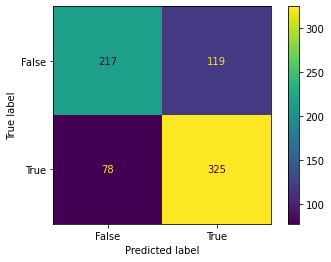

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(gold_file_csv['Label'],u_zero_results['Label']), display_labels = [False, True]).plot()

### One-shot

In [ ]:
u_one_results= unbalanced_data[unbalanced_data['Setting']=='one_shot']

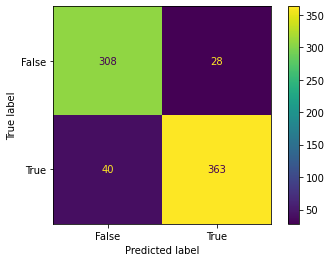

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(gold_file_csv['Label'],u_one_results['Label']), display_labels = [False, True]).plot()

## Balanced

### Zero-shot

In [ ]:
balanced_zero_results = data_results[data_results['Setting']=='zero_shot']

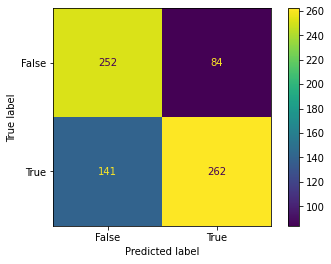

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(gold_file_csv['Label'],balanced_zero_results['Label']), display_labels = [False, True]).plot()

### One-shot

In [ ]:
balanced_one_results = data_results[data_results['Setting']=='one_shot']

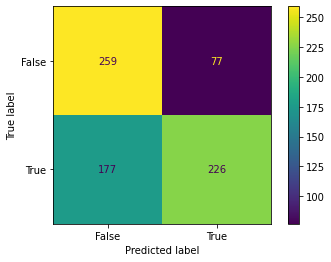

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(gold_file_csv['Label'],balanced_one_results['Label']), display_labels = [False, True]).plot()

In [ ]:
%%shell
jupyter nbconvert --to html Ensemble.ipynb

[NbConvertApp] Converting notebook Ensemble.ipynb to html
[NbConvertApp] Writing 544616 bytes to Ensemble.html
